## 미니프로젝트의 목표!
- Objective 1 : 비정상 데이터를 **정상 데이터로** 만들어봅시다!
- Objective 2: 강의에 활용되었던 분류 모델의 **성능을 높여봅시다!**

# 미니 프로젝트
아래의 순서대로 코드 실습이 진행됩니다. 코드를 실행하는 부분이 어떤 순서에 해당하는지 천천히 확인해보세요.

1. 비정상 데이터를 정상 데이터로 만들기

2. 분산을 일정하게 만들기 - log transformation

3. 차분을 통해 추세 제거하기

4. (추가) 계절 차분을 통해 계절성 제거하기

5. 검정을 통해 정상성 확인하기

6. 시계열 분류

    1. 데이터 다운로드 및 불러오기
    2. 데이터셋 확인(timeseries와 y 확인)
    3. 데이터셋 가공
    4. 데이터셋 나누기
    5. feature extraction
    6. impute
    7. RandomForest 및 XGBoost 사용 및 score 확인
    8. XGBoost plot_importance 확인 및 시각화
    9. Classification report를 통한 검증 및 분석

## 1. 비정상 데이터를 정상 데이터로 만들기
- 데이터가 있는 폴더 연결하기
- tsfresh 설치
- 런타임 재시작
- 필요한 라이브러리 불러오기
- 데이터 불러오기

In [ ]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
!mkdir -p aiffel/time_series_basic
!cp ~/data/AirPassengers.csv aiffel/time_series_basic/

In [ ]:
!pip install tsfresh

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [2]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# air passengers 데이터를 불러옵니다.
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')
ap

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
# 'Month' column을 삭제합니다.
ap = ap.drop('Month', axis=1)
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


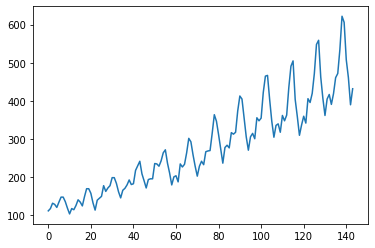

In [5]:
# 초기 데이터 시각화하기
plt.figure()
plt.plot(ap)
plt.show()

### 초기 데이터 분석
- 추세(Trend) [○]
- 계절성(Seasonality) [○]
- 주기(Cycle) [○] - 1년 단위?
- 분산 증가 [○]

#### 결론: 비정상 데이터이다.

In [49]:
# 초기 데이터로 adf 테스트를 수행합니다.
adf_test(ap)

ADF statistics
0.8153688792060498

P-value
0.991880243437641

Lags
13

Nobs
130

Crit
{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}

Icb
996.692930839019


#### 결론: ADF 통계량이 임계값보다 크고 P-value가 높으므로 귀무가설을 기각할 증거가 부족하며, 시계열 데이터가 단위근을 가지고 있다고 판단됩니다. 즉, 정상성을 나타내지 않는다는 것을 시사합니다.

## 2. 분산을 일정하게 만들기 - log transformation
- log transformation을 하는 이유는 다음과 같습니다.
    - 큰 수를 같은 비율의 작은 수로 만들 수 있습니다.
    - 복잡한 계산을 쉽게 만듭니다.
    - 왜도(skewness)와 첨도(kurtosis)를 줄여서 데이터 분석 시 의미있는 결과를 도출하기 위한 것입니다.

In [6]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


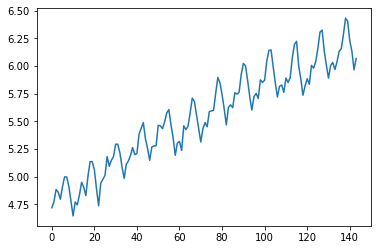

In [7]:
# 분산이 일정해진 것을 눈으로 확인할 수 있습니다.
plt.figure()
plt.plot(log_transformed)
plt.show()

## 3. 차분을 통해 추세 제거하기


In [8]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있습니다.
diffed = log_transformed.diff()
diffed

,#Passengers
0,NaN
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


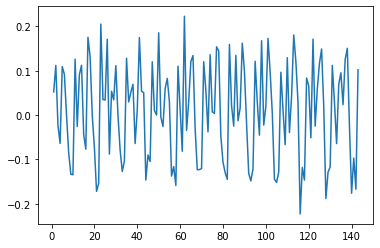

In [9]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(diffed)
plt.show()

## 4. (추가) 계절 차분을 통해 계절성 제거하기
AirPassengers 데이터는 12개월을 주기로 하는 계절성이 포함되어 있습니다. 

이런 경우엔 계절 차분을 통해서 계절성을 데이터에서 제거할 수 있습니다.

In [10]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
seasonally_diffed

,#Passengers
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


In [11]:
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed.dropna(inplace = True)
seasonally_diffed

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


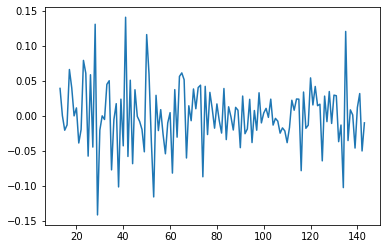

In [12]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

## 5. 검정을 통해 정상성 확인하기
- adfuller : Python에서 statsmodels을 통해 ADF(Augmented Dickey-Fuller) Test를 할 수 있습니다.   
    앞서 Classification report를 통해 Logistic Regression 모델을 검증한 것과 마찬가지로 시계열 데이터를 통계 분석하고 검증할 때 사용합니다.   
    adfuller를 사용하면 대표적으로 다음과 같은 값을 얻을 수 있습니다.
    
    - adf(단위근 검정, Augmented Dickey Fuller) : 정상성을 확인하기 위한 단위근 검정방법
    - p-value(유의 검정) : 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률
    - usedlag : 사용된 시차의 수
    - nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수
    - critical values(임계값) : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
    - icbest : 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print()
    print('P-value')
    print(p_value) # P-value입니다.
    print()
    print('Lags')
    print(lags) # lags입니다.
    print()
    print('Nobs')
    print(nobs)
    print()
    print('Crit')
    print(crit)
    print()
    print('Icb')
    print(icb)

In [14]:
# 계절차분까지 수행한 데이터로 adf 테스트를 수행합니다.
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425

P-value
0.00024859123113838495

Lags
12

Nobs
118

Crit
{'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}

Icb
-415.5597525461335


### 검정 결과 분석
1. ADF Statistics: -4.4433249418311425
- ADF 통계량은 검정 통계량으로, 이 값이 특정 임계값보다 작을수록 데이터가 정상성을 나타낸다.
<br/><br/>
2. P-value: 0.00024859123113838495
- P-value는 귀무가설이 기각될 확률을 나타낸다. 여기서 P-value가 매우 작기 때문에 귀무가설(시계열 데이터가 단위근을 가지고 있다는 가설)을 기각할 수 있다.
<br/><br/>
3. Lags: 12
- ADF 검정에서 사용된 시차(lags)의 수이다. 이 값은 데이터의 자동 회귀 구조를 나타낸다.
<br/><br/>
4. Nobs: 118
- 분석에 사용된 데이터 포인트의 수이다.
<br/><br/>
5. Crit (Critical Values):
- ADF 통계량에 대한 임계값(critical values)이 주어져 있다. 이 임계값과 비교하여 ADF 통계량이 어느 정도의 유의수준에서 기각되는지를 판단할 수 있다. 여기서는 1%, 5%, 10%의 유의수준에 대한 임계값이 제시되어 있다.
<br/><br/>
6. Icb: -415.5597525461335
- 최대 정보 기준(maximum information criterion)이다. 이 값이 낮을수록 모델의 성능이 높다고 볼 수 있다.
<br/><br/>
#### 결론: ADF 통계량이 임계값보다 작고 P-value가 매우 작으므로 귀무가설이 기각되어 시계열 데이터가 정상성을 나타낸다고 할 수 있다.

## 6. 시계열 분류
강의 때 Logistic Regression을 이용한 시계열 분류가 낮은 score를 보였습니다. 앙상블 모델과 더 많은 특징을 활용해서 분류 성능을 높여봅시다!

#### A. 데이터 다운로드 및 불러오기

In [15]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

#### B. 데이터셋 확인(timeseries와 y 확인)

In [16]:
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [17]:
y # true/false가 제시되어 있습니다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

#### C. 데이터셋 가공

In [18]:
def custom_classification_split(x,y,test_size=0.3): # 수업 때 보았던 custom split 함수
    
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = x[~x['id'].isin(id_list)]
    X_test = x[x['id'].isin(id_list)]
    
    return X_train, y_train, X_test, y_test

#### D. 데이터셋 나누기

In [19]:
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries,y,test_size=0.25)

In [20]:
display(X_train)
print('--'*30)
display(y_train)
print('--'*30)
display(X_test)
print('--'*30)
display(y_test)

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
75,6,0,-1,2,57,-10,-3,0
76,6,1,-2,3,60,-12,-4,-1
77,6,2,-1,2,63,-12,-6,1
78,6,3,1,3,62,-11,0,0
79,6,4,-3,2,56,-9,-4,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


------------------------------------------------------------


6      True
7      True
8      True
9      True
10     True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 67, dtype: bool

------------------------------------------------------------


,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
505,34,10,3,4,65,-11,1,0
506,34,11,1,3,62,-11,-1,-1
507,34,12,-1,0,60,-8,-7,0
508,34,13,-1,0,59,-8,-7,0


------------------------------------------------------------


2      True
3      True
4      True
5      True
6      True
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
dtype: bool

#### E. Feature extraction

In [21]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

# EfficientParameters는 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징을 생성합니다.
settings = EfficientFCParameters()

In [22]:
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:16<00:00, 25.04it/s]


In [23]:
comprehensive_features_train

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,NaN,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,NaN,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,NaN,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,NaN,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,NaN,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,NaN,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,NaN,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,NaN,40.285714


In [24]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:04<00:00, 25.43it/s]


In [25]:
comprehensive_features_test

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,NaN,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,NaN,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,NaN,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,NaN,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,NaN,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,NaN,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,NaN,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,NaN,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,NaN,3.714286


#### 추출된 특징 시각화하기
- 값이 0과 1로만 이루어진 데이터, 분산이 작은 데이터, 분산이 큰 데이터들이 있다.

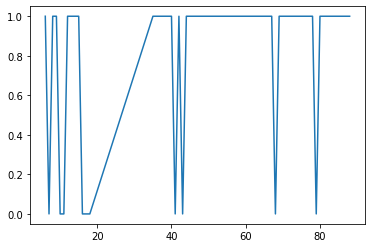

In [26]:
plt.plot(comprehensive_features_train['F_x__variance_larger_than_standard_deviation'])
plt.show()

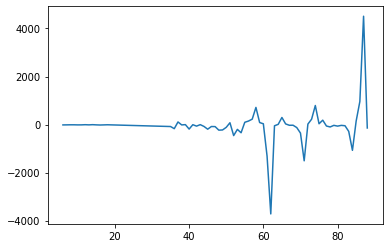

In [27]:
plt.plot(comprehensive_features_train['F_x__sum_values'])
plt.show()

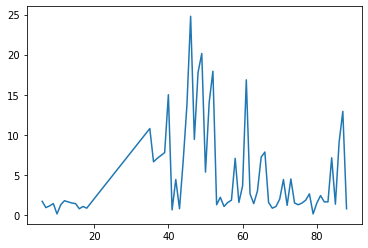

In [28]:
plt.plot(comprehensive_features_train['F_x__mean_abs_change'])
plt.show()

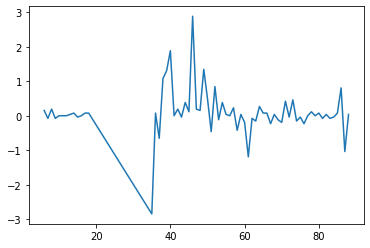

In [29]:
plt.plot(comprehensive_features_train['F_x__mean_second_derivative_central'])
plt.show()

#### F. Impute - 간단하게 데이터 전처리하기

In [30]:
impute(comprehensive_features_train)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [31]:
impute(comprehensive_features_test)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


#### G. RandomForest 및 XGBoost 사용 및 score 확인

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state=2024)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=2024)

In [42]:
# test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다.
rf_clf.score(comprehensive_features_test, y_test)

0.9047619047619048

In [43]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3, random_state=2024)

# XGBoost 모델을 학습시킵니다.
xgb_clf.fit(comprehensive_features_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:50:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=2, num_parallel_tree=1, random_state=2024,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf.score(comprehensive_features_test, y_test)

1.0

#### H. XGBoost plot_importance 확인 및 시각화

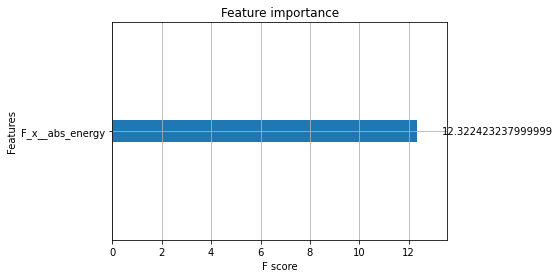

In [46]:
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다.
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [47]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

1

In [53]:
(timeseries['F_x'][timeseries['id']==6]**2).sum()

39

In [57]:
comprehensive_features_train.loc[6, 'F_x__abs_energy']

39.0

F_x__abs_energy는 F_x 값의 id별 제곱의 합으로 F_x의 전반적인 크기 또는 강도를 나타낸다.

해당 데이터에서 이 변수만이 유의미하다.

#### I. Classification report를 통한 검증 및 분석

In [48]:
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

1. True 클래스에 대한 결과:

Precision (정밀도): 1.0 (100%)
Recall (재현율): 1.0 (100%)
F1-score: 1.0 (100%)
Support: 16 (True 클래스에 속하는 총 샘플 수)
<br/><br/>
2. False 클래스에 대한 결과:

Precision (정밀도): 1.0 (100%)
Recall (재현율): 1.0 (100%)
F1-score: 1.0 (100%)
Support: 5 (False 클래스에 속하는 총 샘플 수)
<br/><br/>
3. 전체 모델 성능:

- Accuracy (정확도): 1.0 (100%)
- Macro average: 각 클래스에 대한 평균값
    - Precision: 1.0 (100%)
    - Recall: 1.0 (100%)
    - F1-score: 1.0 (100%)
    - Support: 21 (전체 샘플 수)
- Weighted average: 클래스별로 가중치를 부여하여 계산한 평균값
    - Precision: 1.0 (100%)
    - Recall: 1.0 (100%)
    - F1-score: 1.0 (100%)
    - Support: 21 (전체 샘플 수)
<br/><br/>
#### 결론: 해석하면, 모델이 True와 False 클래스 모두에 대해 매우 우수한 성능을 보이고 있으며, 전체적으로도 정확도 100%를 기록하고 있습니다. Precision, Recall, F1-score 등의 지표가 모두 1.0으로 나타나므로, 이 모델은 주어진 데이터셋에 대해 완벽한 예측을 수행하는 것으로 보입니다.

### 회고
어제 오늘 시계열 데이터의 정상성과 정상성 검증 그리고 비정상 데이터를 정상데이터로 만들고 모델에 넣어 분류 예측까지 실행했다.
오늘 프로젝트에 나온 부분인 정상성 데이터와 정상성 데이터로 만들고 모델 예측 하는는 **방법**은 이해가 잘 됐지만 이를 통해 어떻게 활용할 수 있는지는 잘 모르겠다. 또한 어제 공부한 내용인 ACF와 PACF에 대한 내용도 조금 더 복습이 필요하다.